In [1]:
import numpy as np
import model

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black')

from mrashpen.inference.penalized_regression import PenalizedRegression as PLR
from mrashpen.inference.mrash_wrapR          import MrASHR
from mrashpen.models.plr_ash                 import PenalizedMrASH
from mrashpen.models.normal_means_ash_scaled import NormalMeansASHScaled
from mrashpen.inference.ebfit                import ebfit
from mrashpen.inference                      import lbfgsfit
from mrashpen.utils                          import R_lasso
from mrashpen.utils                          import R_trendfilter

def initialize_ash_prior(k, scale = 2, sparsity = None):
    w = np.zeros(k)
    w[0] = 1 / k if sparsity is None else sparsity
    w[1:(k-1)] = np.repeat((1 - w[0])/(k-1), (k - 2))
    w[k-1] = 1 - np.sum(w)
    sk2 = np.square((np.power(scale, np.arange(k) / k) - 1))
    prior_grid = np.sqrt(sk2)
    return w, prior_grid

### Generate data using B-splines and map to trendfiltering basis function

In [2]:
%%html
<style>
table {align:left; display: block}
</style>

| Variables | Description | 
| :- | :- |
| _x_ | the real x-axis, size _n_ |
| _y_ | the observed variables, size _n_ |
| _degree_ | degree of the spline |
| _nknots_ | number of knots |
| _knots_ | location of the knots on the x-axis, size _nknots_ |
| _H_ | trendfiltering basis matrix, size _n_ x _n_ |
| _btrue_ | coefficients for _H_, size _n_ |
| _G_ | B-spline basis matrix, size _n_ x _nknots_ |
| _Gb_ | coefficients for _G_, size _nknots_ |

y = H * btrue = G * Gb

Signal-to-noise ratio: 169.569


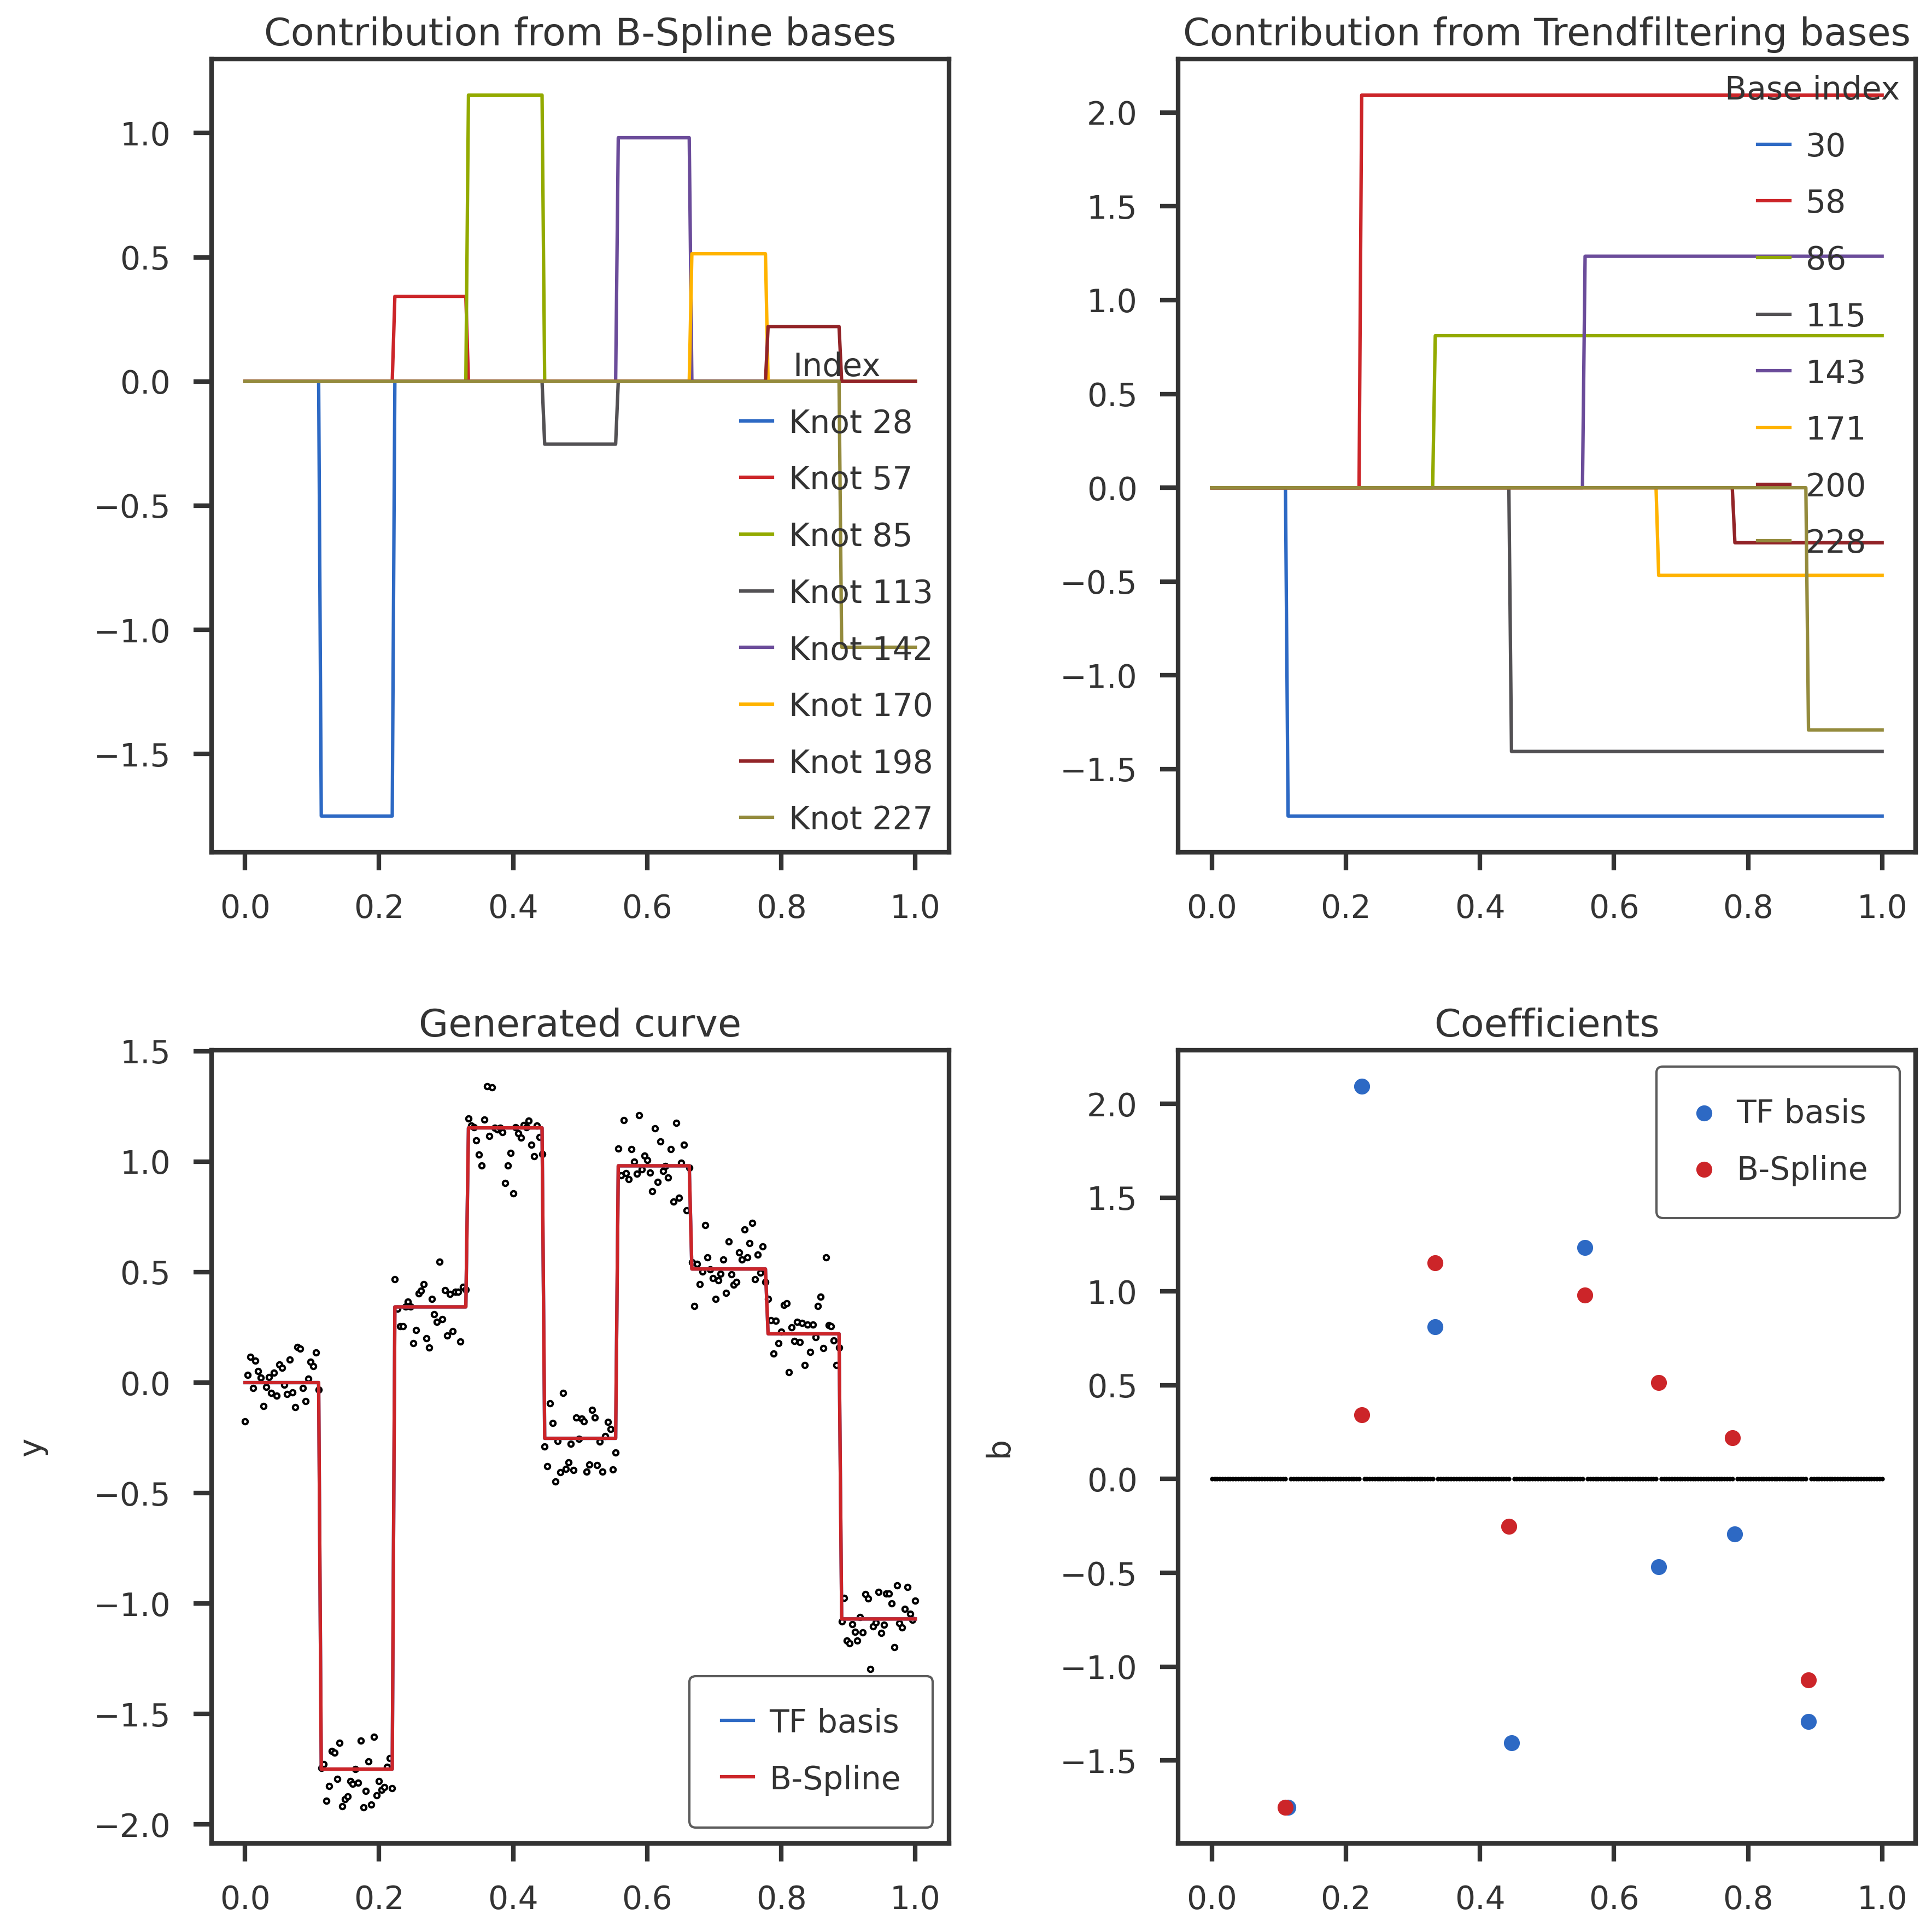

In [3]:
n = 256
x = np.linspace(0, 1, n)
np.random.seed(100)

# Zeroth degree trendfiltering
nknots = 8
degree = 0
strue = 0.1
include_intercept = False
knots = np.linspace(0, 1, nknots+2)[1:-1]
bfix = np.random.normal(0, 1, size = nknots + degree)


H, y, ytest, btrue, snr, G, Gb = model.changepoint_from_bspline(x, knots, strue, 
                                            degree = degree, 
                                            signal = "fixed", bfix = bfix,
                                            seed = 100, include_intercept = include_intercept,
                                            get_bsplines = True, eps = 1e-8
                                           )
print(f"Signal-to-noise ratio: {snr:.3f}")

fig = plt.figure(figsize = (12, 12))
axlist = [fig.add_subplot(2,2,i+1) for i in range(4)]
model.plot_data_from_bspline(axlist, x, y, knots, degree, G, Gb, H, btrue)
plt.tight_layout()
plt.subplots_adjust(hspace = 0.25)
plt.show()

In [4]:
def center_and_scale_tfbasis(Z, b):
    '''
    Basis matrix Z is always 2D.
    b is the coefficient vector
    The first column of Z is all 1, hence it has zero standard deviation.
    '''
    dim  = Z.ndim
    std  = np.std(Z, axis = 0)
    if std[0] == 0:
        # do not scale the first column
        std[0] = 1.0
    Znew = Z / std
    Znew[:, 1:] = Znew[:, 1:] - np.mean(Znew[:, 1:], axis = 0).reshape(1, -1)
    bnew = b * std
    ## add the intercept
    bnew[0] = - np.sum(Znew[0, :] * bnew)
    '''
    alternative
    bnew = np.dot(np.dot(np.linalg.inv(Znew), Z), b)
    '''
    return Znew, bnew

Hscale, bscale = center_and_scale_tfbasis(H, btrue)
dj = np.sum(np.square(Hscale), axis = 0)
print (dj)

[256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256.
 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256.
 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256.
 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256.
 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256.
 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256.
 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256.
 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256.
 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256.
 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256.
 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256.
 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256.
 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256.
 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256.
 256. 

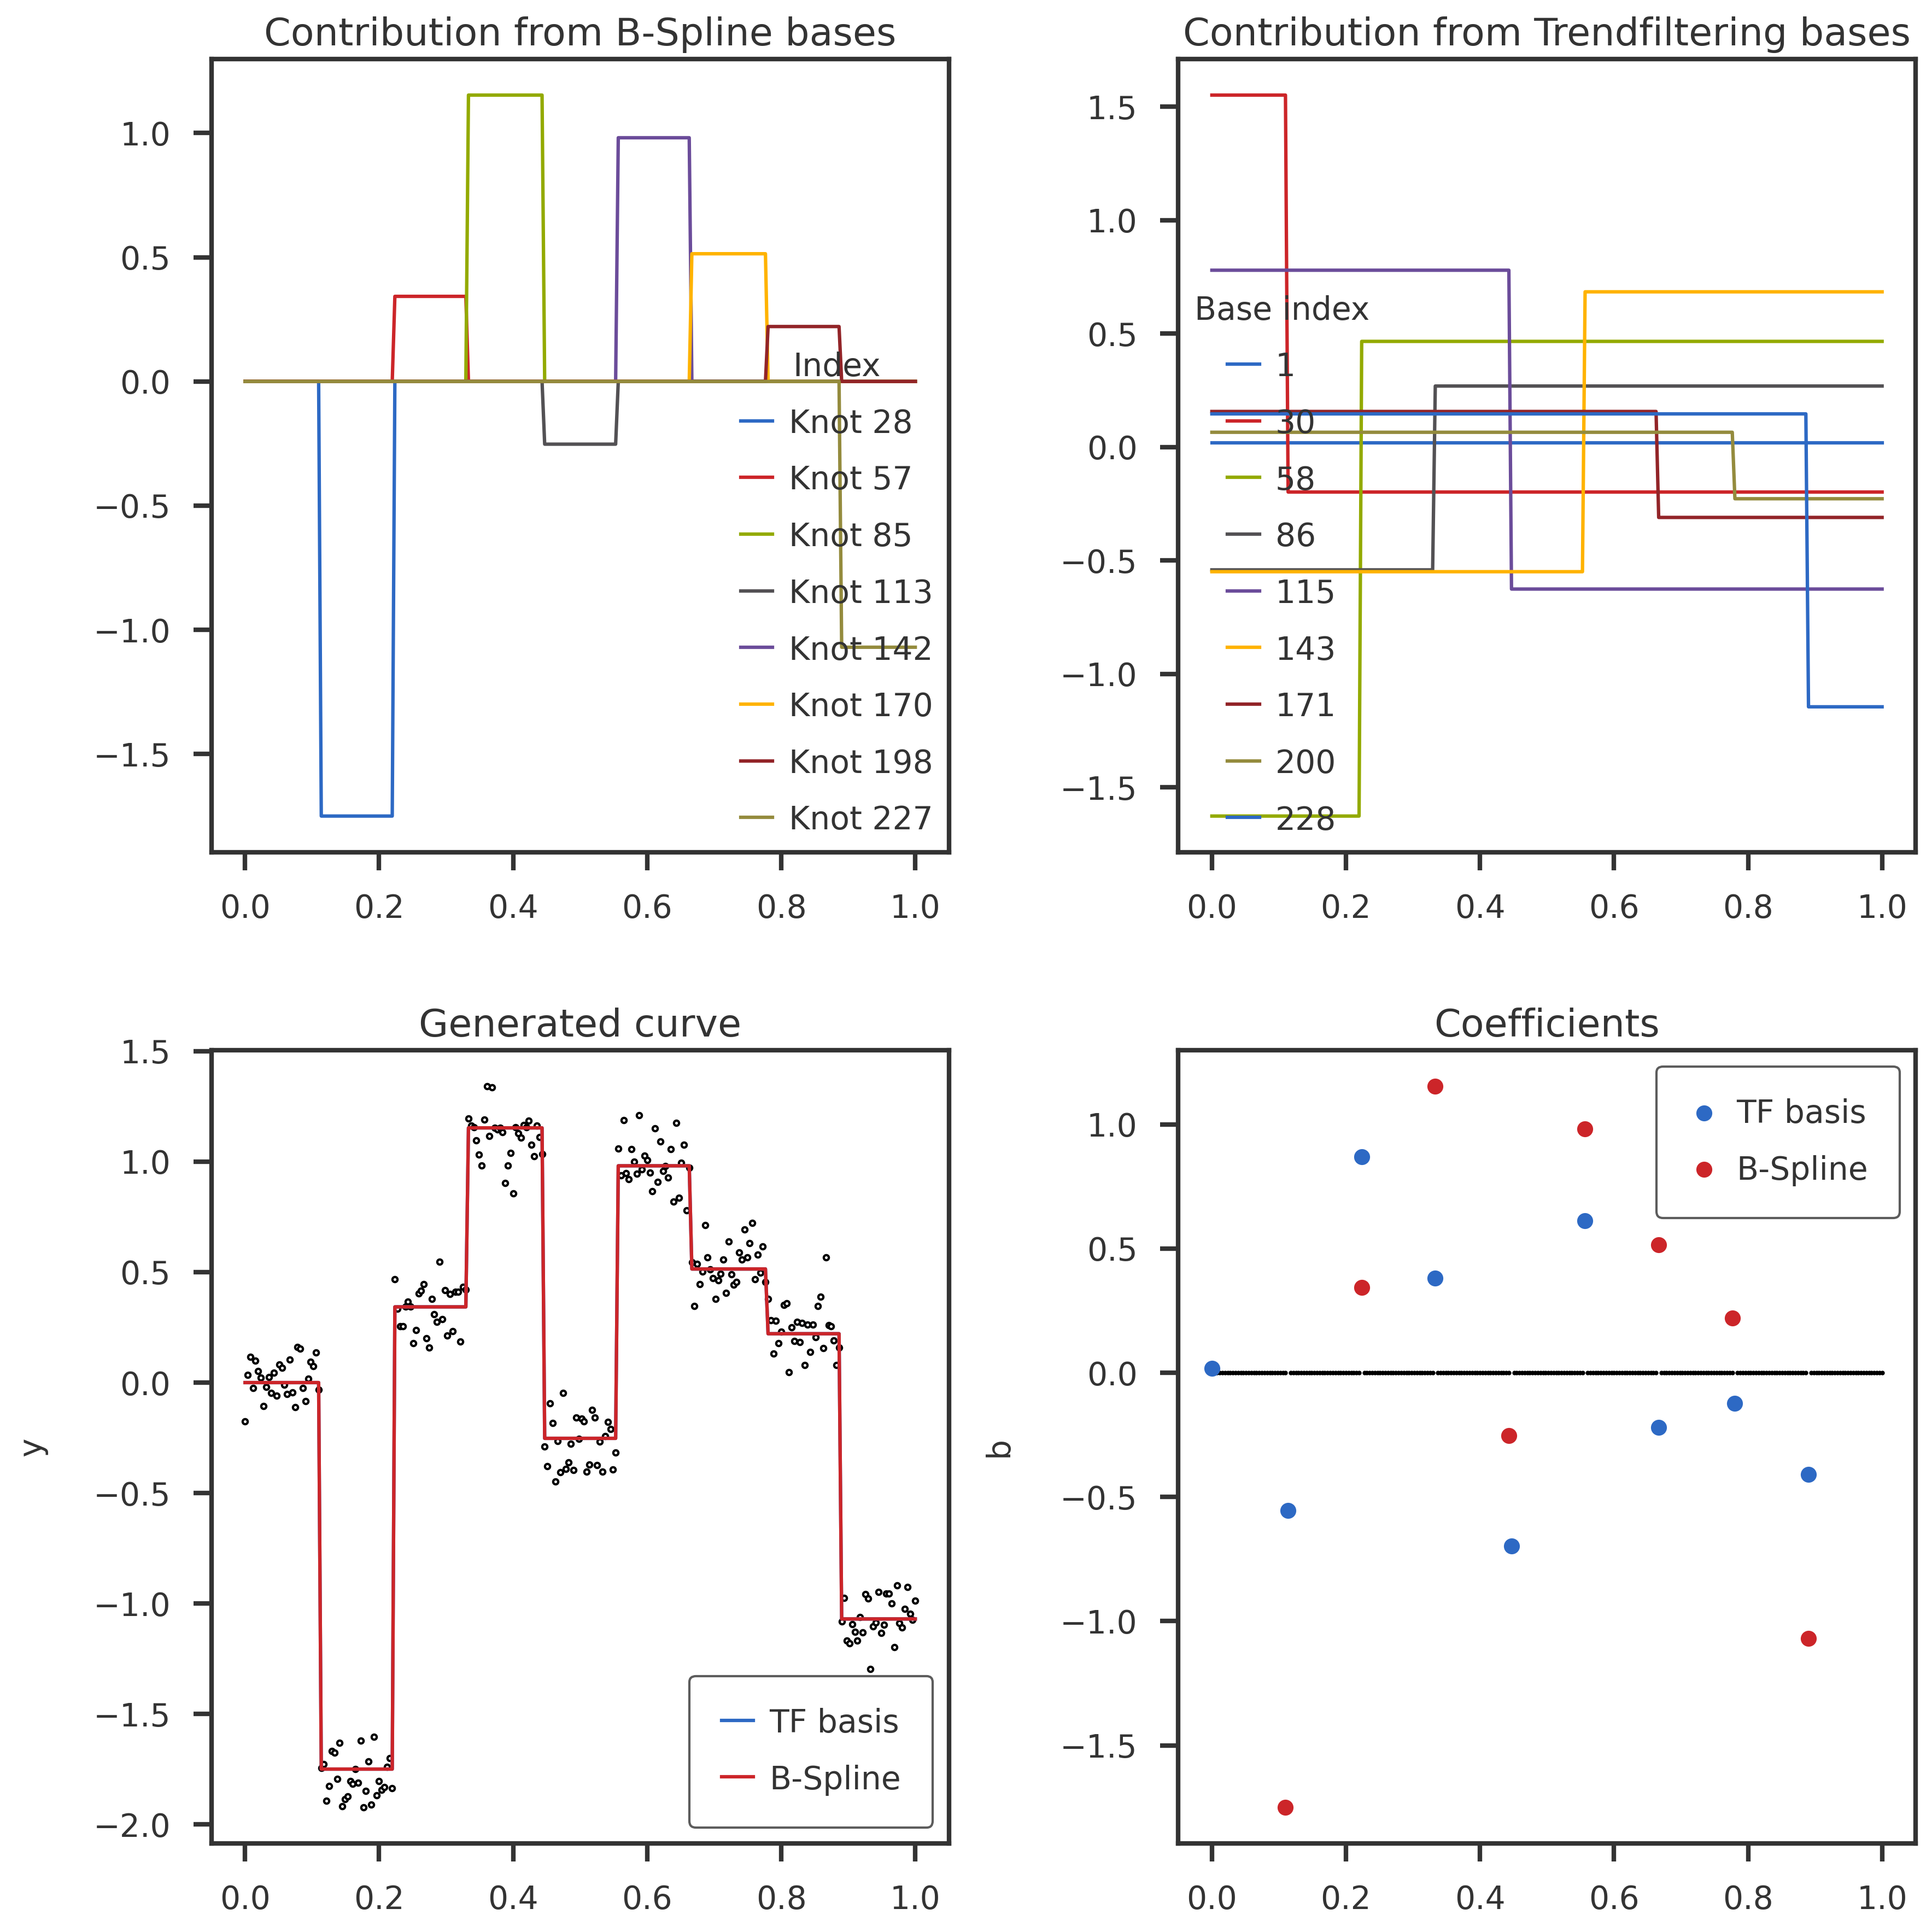

In [5]:
fig = plt.figure(figsize = (12, 12))
axlist = [fig.add_subplot(2,2,i+1) for i in range(4)]
model.plot_data_from_bspline(axlist, x, y, knots, degree, G, Gb, Hscale, bscale)
plt.tight_layout()
plt.subplots_adjust(hspace = 0.25)
plt.show()

### Trendfiltering using Genlasso

In [6]:
tf_y, tf_fit = R_trendfilter.fit(y, order = degree)
tf_basis_inv = model.trendfiltering_basis_matrix_inverse(n, degree) 
tf_bhat  = np.dot(tf_basis_inv, tf_y)

R[write to console]: Loading required package: Matrix



Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 



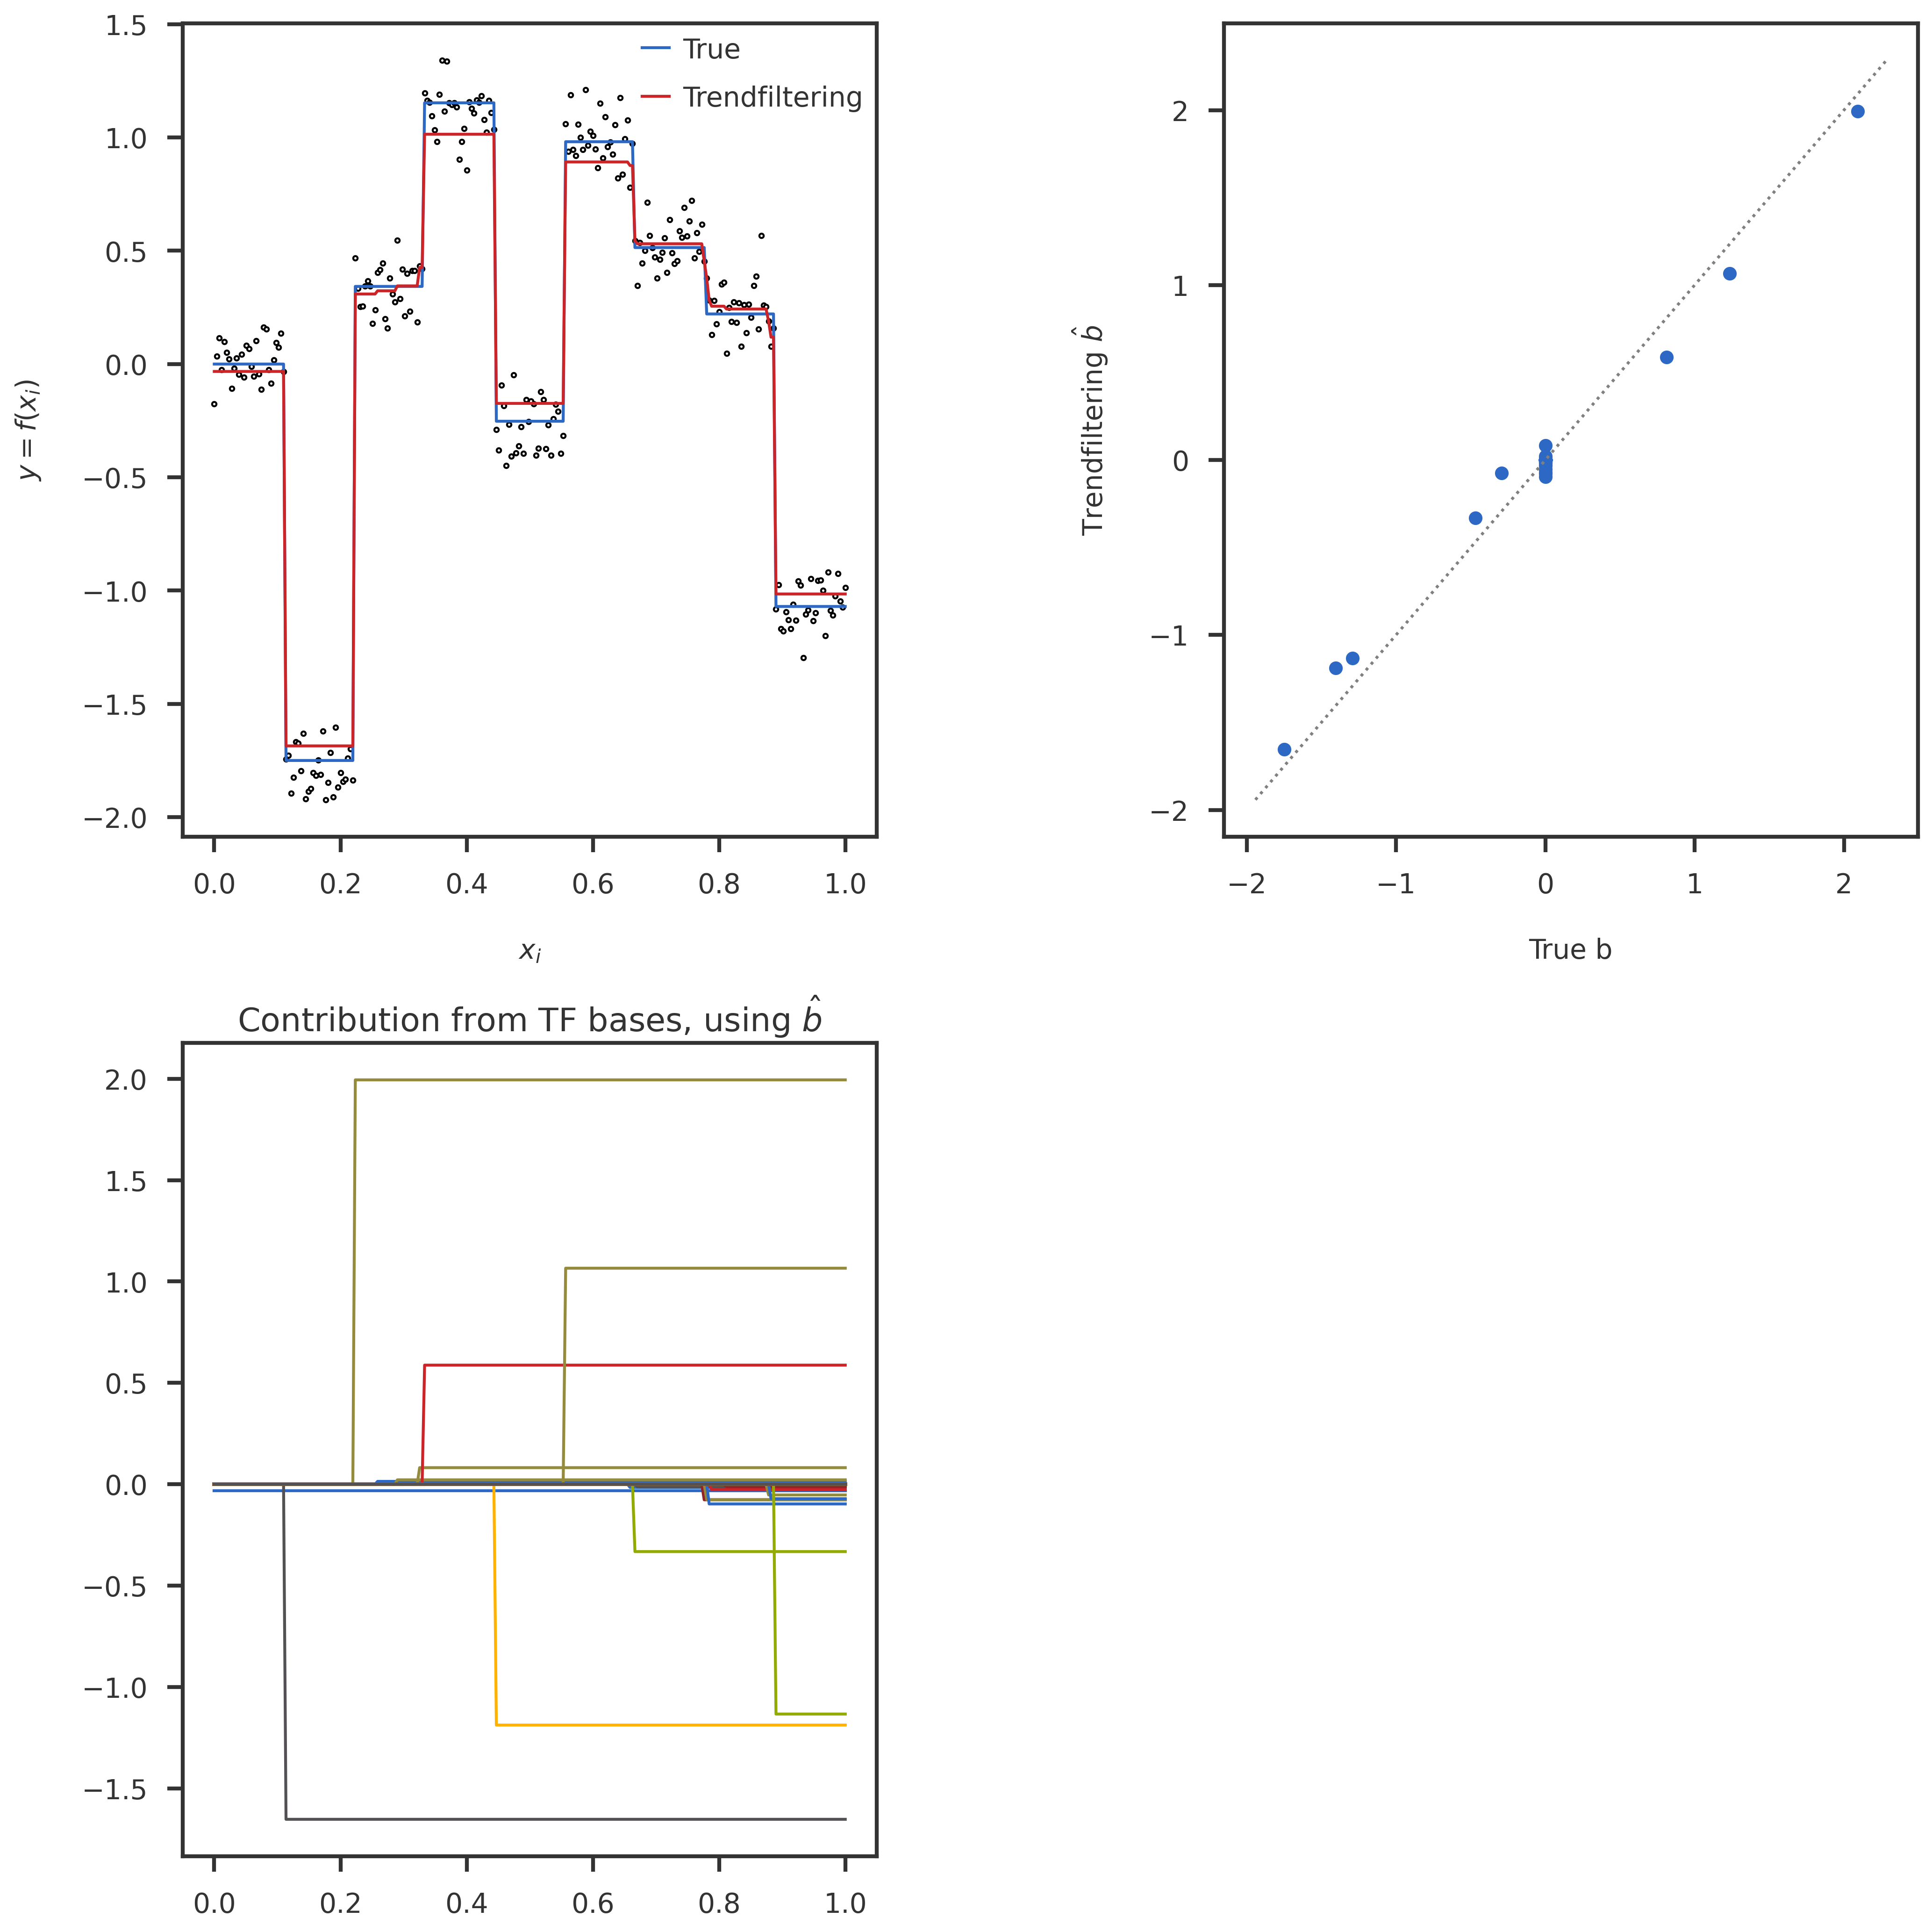

In [7]:
fig = plt.figure(figsize = (14, 14))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax1.scatter(x, y, s = 5, edgecolor = 'black', facecolor='white')
ax1.plot(x, np.dot(H, btrue), label = "True")
ax1.plot(x, tf_y, label = "Trendfiltering")
ax1.legend()
ax1.set_xlabel(r"$x_i$")
ax1.set_ylabel(r"$y = f(x_i)$")

ax2.scatter(btrue, tf_bhat)
mpl_utils.plot_diag(ax2)
ax2.set_xlabel("True b")
ax2.set_ylabel(r"Trendfiltering $\hat{b}$")

for i,b in enumerate(tf_bhat):
    if np.abs(b) != 0:
        ax3.plot(x, b * H[:, i])
ax3.set_title(r"Contribution from TF bases, using $\hat{b}$")
        
plt.tight_layout()
plt.subplots_adjust(wspace = 0.5)
plt.show()

### Mr.Ash and Penalized Mr.Ash 

#### Initial values from genlasso

We will use scaled basis matrix for Mr.Ash, hence we also scale the initial coefficients obtained from trendfiltering.

In [8]:
k = 10
scale = 2.0
s2init = np.var(y - np.dot(H, tf_bhat))
_, binit = center_and_scale_tfbasis(H, tf_bhat)
winit, sk = initialize_ash_prior(k, scale = scale, sparsity = 0.8)
print (r"Standard deviation of prior mixture components:")
print (', '.join([f"{x:.3f}" for x in sk]))
print ()
print ("Coefficients of prior mixture components:")
print (', '.join([f"{x:.3f}" for x in winit]))

Standard deviation of prior mixture components:
0.000, 0.072, 0.149, 0.231, 0.320, 0.414, 0.516, 0.625, 0.741, 0.866

Coefficients of prior mixture components:
0.800, 0.022, 0.022, 0.022, 0.022, 0.022, 0.022, 0.022, 0.022, 0.022


In [9]:
'''
mr.ash.alpha
'''
mrash_r = MrASHR(option = "r2py", debug = False)
mrash_r.fit(Hscale, y, sk, binit = binit, winit = winit, s2init = s2init)

Mr.ASH terminated at iteration 126.


In [10]:
'''
Do not use the initial theta for mr.ash.pen
'''
plr_lbfgs_noinit = PLR(method = 'L-BFGS-B', is_prior_scaled = True, function_call = 'fortran',
                debug = False, display_progress = False, calculate_elbo = True,
                maxiter = 2000, tol = 1e-8)
plr_lbfgs_noinit.fit(Hscale, y, sk, binit = binit, winit = winit, s2init = s2init)

mr.ash.pen terminated at iteration 434.


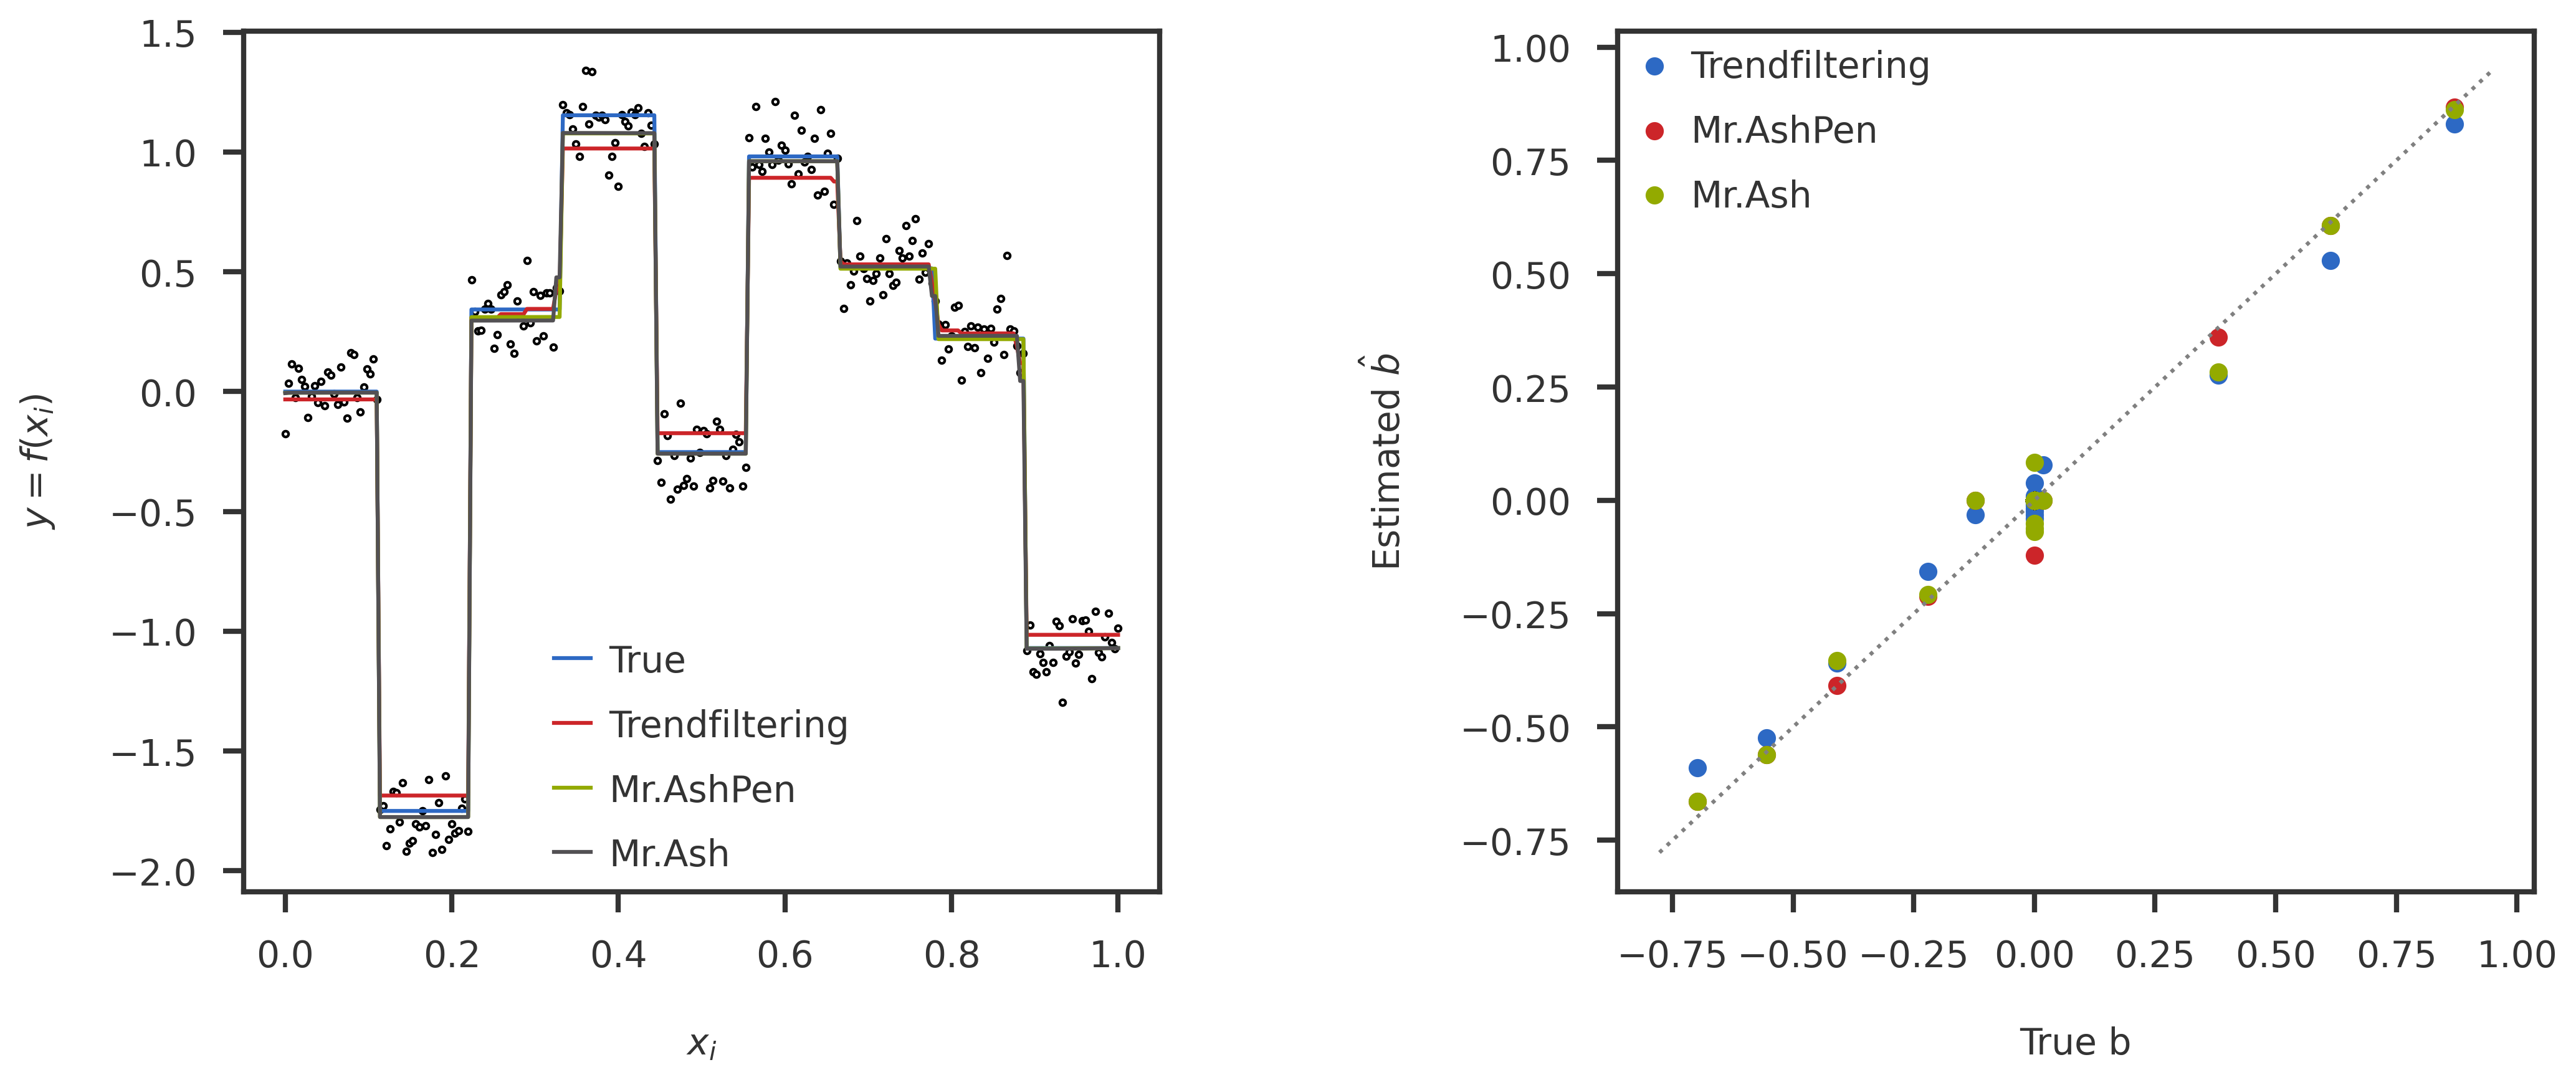

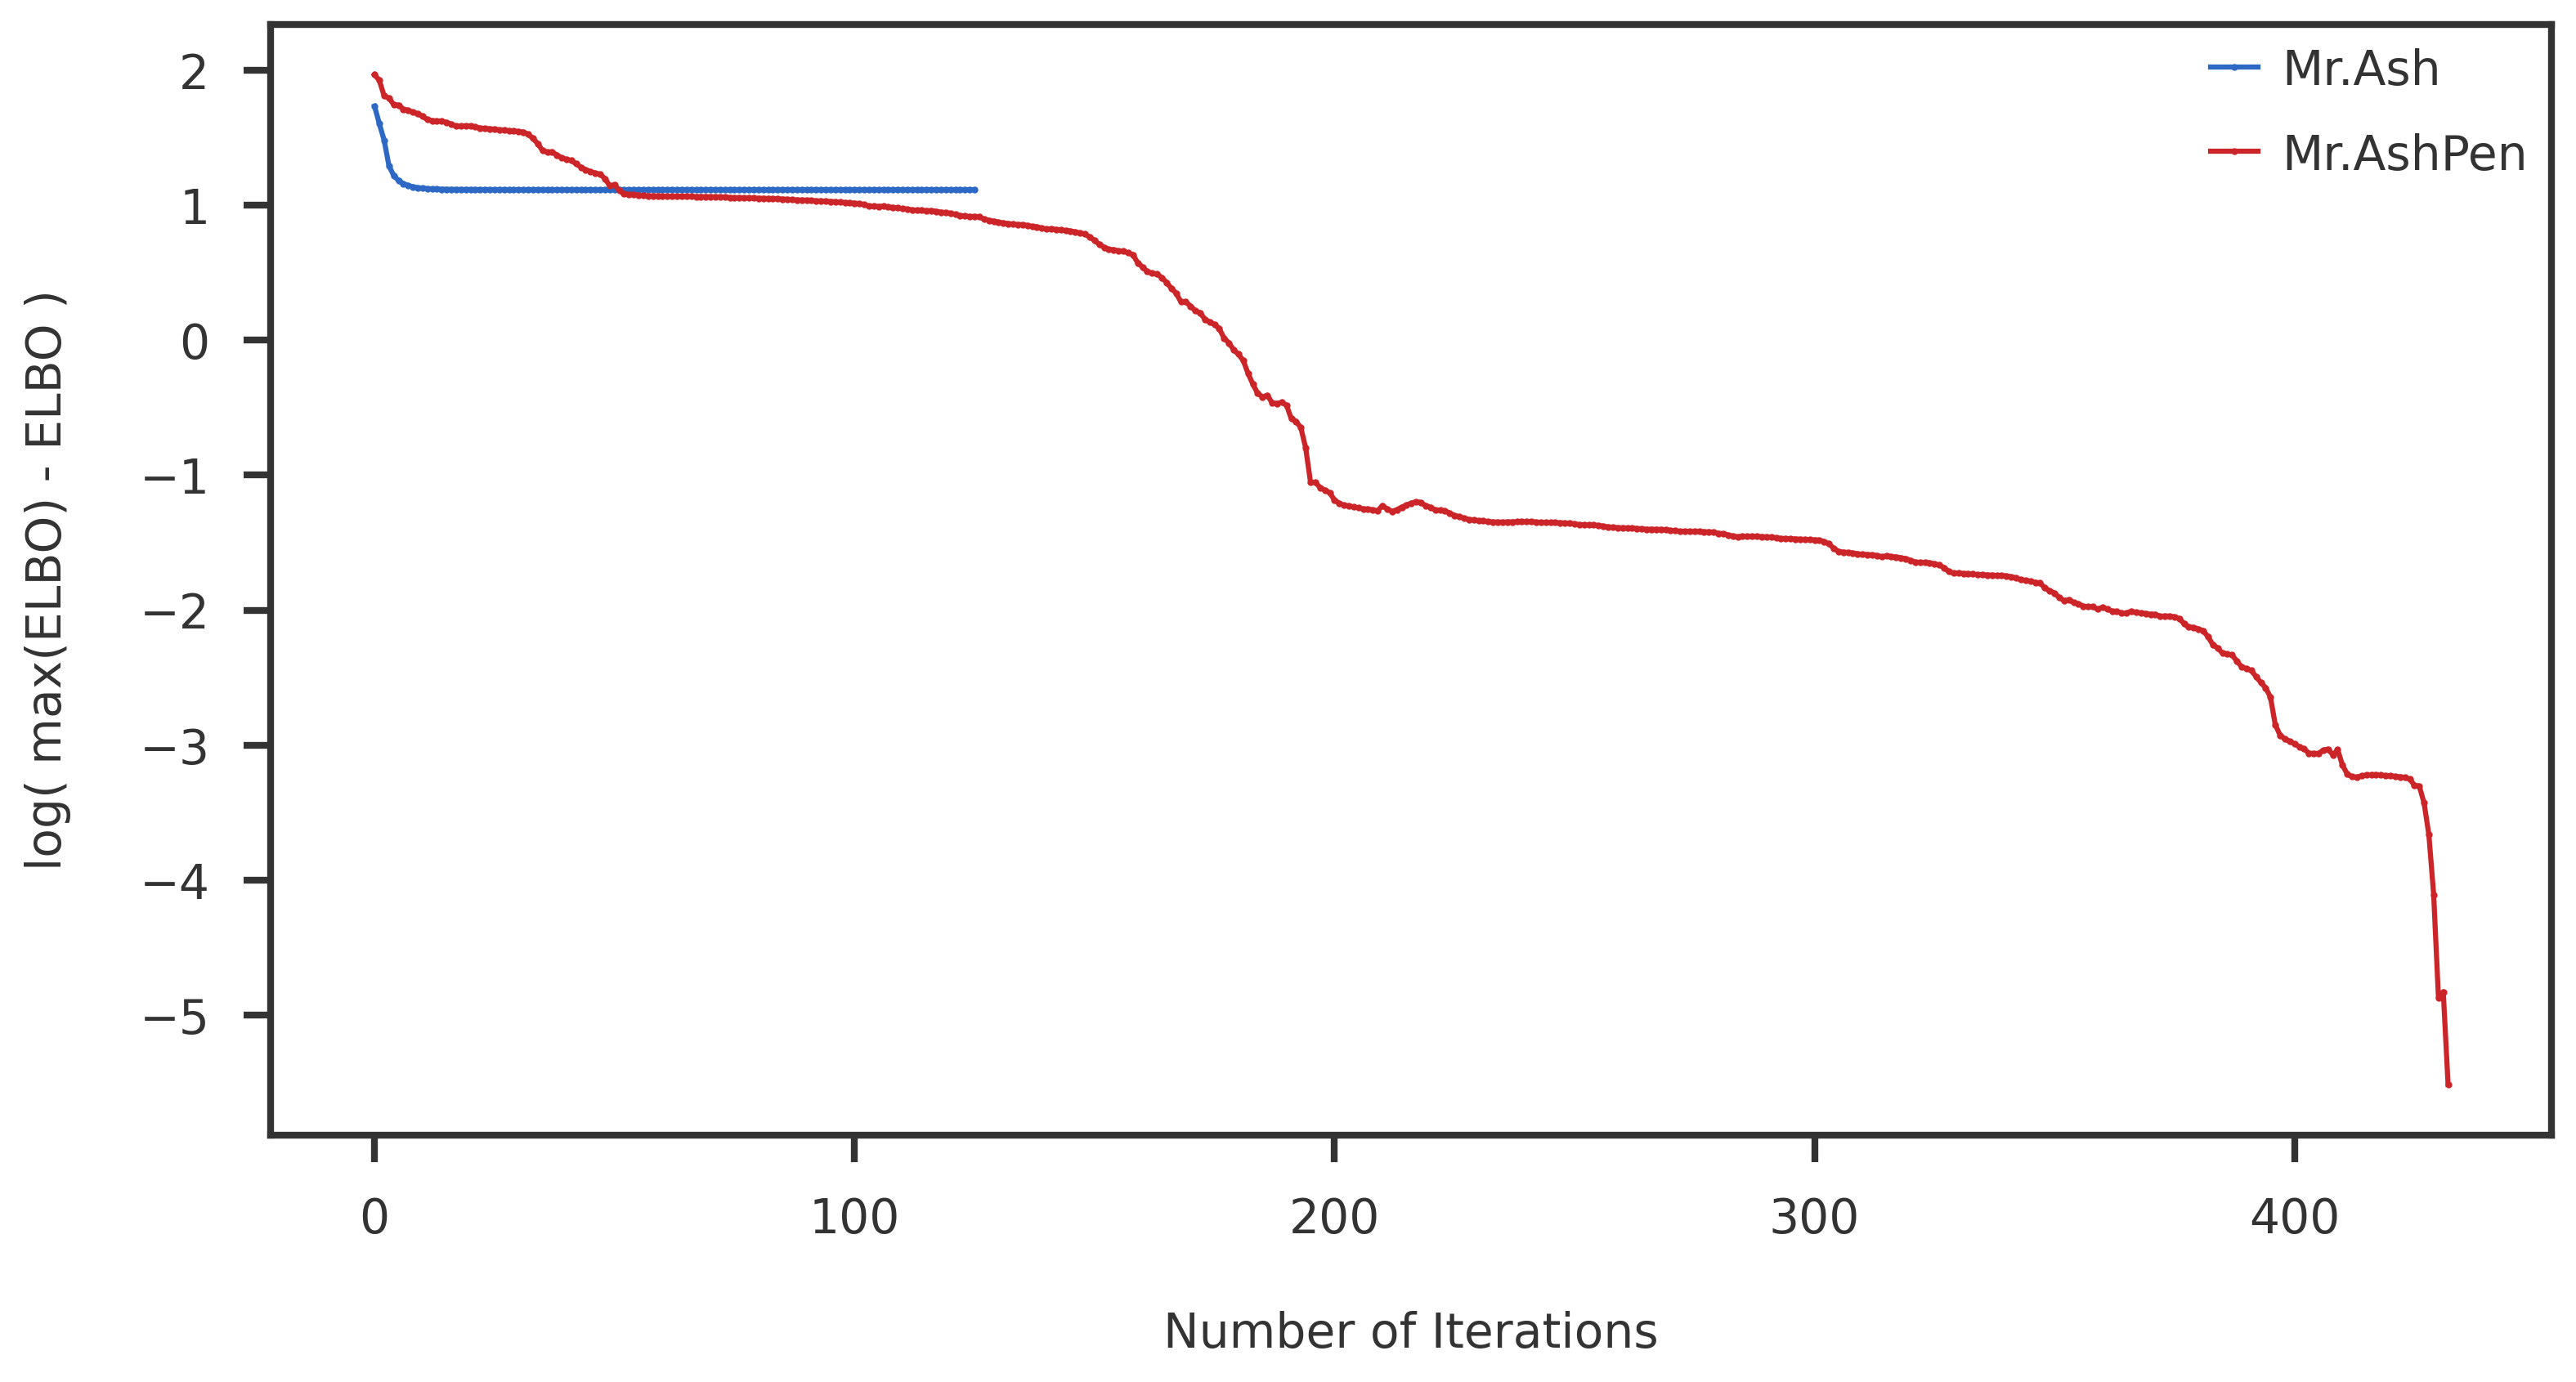

In [11]:
fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.scatter(x, y, s = 5, edgecolor = 'black', facecolor='white')
ax1.plot(x, np.dot(H, btrue), label = "True")
ax1.plot(x, tf_y, label = "Trendfiltering")
ax1.plot(x, np.dot(Hscale, plr_lbfgs_noinit.coef), label = "Mr.AshPen")
ax1.plot(x, np.dot(Hscale, mrash_r.coef), label = "Mr.Ash")
ax1.legend()

ax1.set_xlabel(r"$x_i$")
ax1.set_ylabel(r"$y = f(x_i)$")
ax2.scatter(bscale, binit, label = "Trendfiltering")
ax2.scatter(bscale, plr_lbfgs_noinit.coef, label = "Mr.AshPen")
ax2.scatter(bscale, mrash_r.coef, label = "Mr.Ash")
mpl_utils.plot_diag(ax2)
ax2.set_xlabel("True b")
ax2.set_ylabel(r"Estimated $\hat{b}$")
ax2.legend()
plt.tight_layout()
plt.subplots_adjust(wspace = 0.5)
plt.show()

fig = plt.figure(figsize = (12, 6))
ax1 = fig.add_subplot(111)
objs = [mrash_r.obj_path, plr_lbfgs_noinit.elbo_path]
methods = ["Mr.Ash", "Mr.AshPen"]
nwarm = [0, 0]
objmin  = np.min([np.min(x) for x in objs])
for obj, method, iteq in zip(objs, methods, nwarm):
    m_obj = np.array(obj)[iteq:] - objmin
    m_obj = m_obj[m_obj > 0]
    ax1.plot(range(iteq, len(m_obj) + iteq), np.log10(m_obj), label = method, 
             marker = 'o', markersize = 1)
ax1.legend()
ax1.set_xlabel("Number of Iterations")
ax1.set_ylabel("log( max(ELBO) - ELBO )")
plt.show()